In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
files = []
files.append(r'C:\AI_project\fault_detection\SKAB\data\valve1\0.csv')
data = pd.read_csv(files[0],sep=';', index_col='datetime', parse_dates=True)
data.head(), data.shape

(                     Accelerometer1RMS  Accelerometer2RMS  Current  Pressure  \
 datetime                                                                       
 2020-03-09 10:14:33           0.026588           0.040111  1.33020  0.054711   
 2020-03-09 10:14:34           0.026170           0.040452  1.35399  0.382638   
 2020-03-09 10:14:35           0.026199           0.039419  1.54006  0.710565   
 2020-03-09 10:14:36           0.026027           0.039641  1.33458  0.382638   
 2020-03-09 10:14:37           0.026290           0.040273  1.07851 -0.273216   
 
                      Temperature  Thermocouple  Voltage  Volume Flow RateRMS  \
 datetime                                                                       
 2020-03-09 10:14:33      79.3366       26.0199  233.062                 32.0   
 2020-03-09 10:14:34      79.5158       26.0258  236.040                 32.0   
 2020-03-09 10:14:35      79.3756       26.0265  251.380                 32.0   
 2020-03-09 10:14:36      

In [3]:
data.describe()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
count,1147.000000,1147.000000,1147.000000,1147.000000,1147.000000,1147.000000,1147.000000,1147.000000,1147.000000,1147.000000
mean,0.026521,0.040174,1.004630,0.084159,77.436352,25.958171,230.927635,32.022679,0.349608,0.003487
std,0.000329,0.000774,0.268688,0.249567,1.745585,0.078456,10.748393,0.457728,0.477054,0.058977
min,0.025553,0.038072,0.388229,-0.601143,74.237000,25.829900,203.967000,31.000000,0.000000,0.000000
25%,0.026293,0.039631,0.794215,0.054711,75.663000,25.878800,225.340500,32.000000,0.000000,0.000000
50%,0.026520,0.040172,1.035130,0.054711,78.383300,25.954800,231.339000,32.000000,0.000000,0.000000
75%,0.026743,0.040697,1.221525,0.382638,78.917750,26.020300,237.099500,32.000000,1.000000,0.000000
max,0.027489,0.043046,1.662610,0.710565,79.889100,26.104400,255.324000,32.998600,1.000000,1.000000


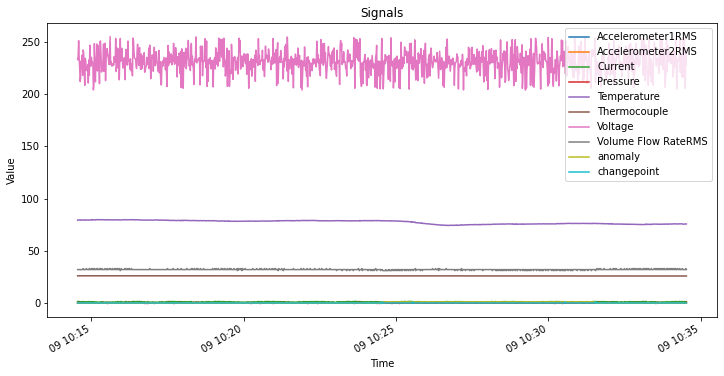

In [4]:
data.plot(figsize=(12,6))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

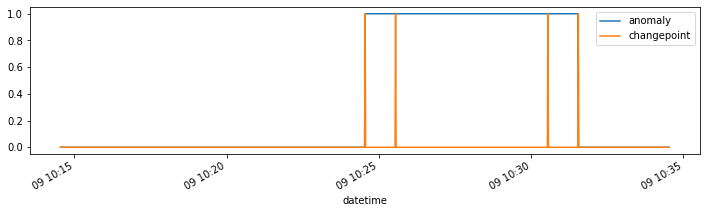

In [5]:
data.anomaly.plot(figsize=(12,3))
data.changepoint.plot()
plt.legend()
plt.show()

In [6]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(n_estimators=100, contamination=0.14, max_features=0.1, max_samples=0.9)
#clf = IsolationForest()

In [7]:
def best_parameter(n_estimator, contamination, max_feature, max_sample, train):
    best_f1 = -1
    estimator_1 = 1
    for estimator in n_estimator:
        for conta in contamination:
            for feature in max_feature:
                for sample in max_sample:
                    clf = IsolationForest(n_estimators=estimator, contamination=conta, max_features=feature, max_samples=sample)
                    clf.fit(train[0:600])
                    prediction = clf.predict(train)
                    predict_outlier = np.maximum(prediction * -1, 0)
                    predict_outlier = pd.Series(predict_outlier, index=data.index,dtype=float)
                    true_positive = np.sum(predict_outlier * true_outlier)
                    false_positive = np.sum(predict_outlier*(1 - true_outlier))
                    false_negative = np.sum((1 - predict_outlier)*true_outlier)

                    epsilon = 1e-7
                    precision = true_positive / (true_positive + false_positive + epsilon)
                    recall = true_positive / (true_positive + false_negative + epsilon)
                    f1 = 2 * precision * recall / ( precision + recall +epsilon)

                    if estimator_1 < estimator:
                        estimator_1 = estimator
                        print(estimator_1)

                    if best_f1 <= f1:
                        best_f1 = f1
                        estimator_1 = estimator
                        conta_1 = conta
                        precision_1 = precision
                        recall_1 = recall
                        feature_1 = feature
                        sample_1 = sample
                        print('n_estimator:{}\t contamination:{}\t precision:{:.2f}\t recall:{:.2f}\t \
           feature:{}\t sample:{} f1:{:.2f}'.format(estimator_1, conta_1, precision_1, recall_1,feature_1, sample_1, best_f1))


    print('best n_estimator:{}\t contamination:{}\t precision:{:.2f}\t recall:{:.2f}\t \
           feature:{}\t sample:{} f1:{:.2f}'.format(estimator_1, conta_1, precision_1, recall_1,feature_1, sample_1, best_f1))
        


In [8]:
train = data.drop(['anomaly', 'changepoint'], axis=1)
train.shape

(1147, 8)

In [9]:
clf.fit(train[0:600])
prediction = clf.predict(train)
predict_outlier = np.maximum(prediction * -1, 0)
predict_outlier = pd.Series(predict_outlier, index=data.index,dtype=float)

In [10]:
true_outlier = data.anomaly
true_outlier.shape

(1147,)

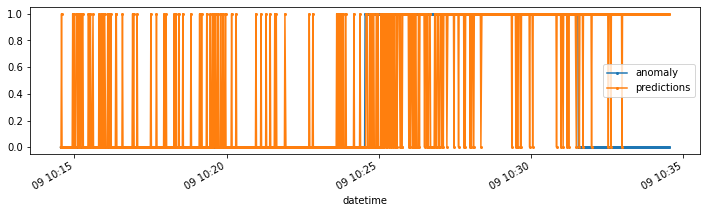

In [11]:
true_outlier.plot(marker='o', markersize=2)
predict_outlier.plot(figsize=(12,3), label='predictions', marker='o', markersize=2)
plt.legend()

In [12]:
number_predict_outlier = predict_outlier.sum()
number_true_outlier = true_outlier.sum()
number_predict_outlier, number_true_outlier

(549.0, 401.0)

In [13]:
true_positive = np.sum(predict_outlier * true_outlier)
false_positive = np.sum(predict_outlier*(1 - true_outlier))
false_negative = np.sum((1 - predict_outlier)*true_outlier)

epsilon = 1e-7
precision = true_positive / (true_positive + false_positive + epsilon)
recall = true_positive / (true_positive + false_negative + epsilon)
f1 = 2 * precision * recall / ( precision + recall +epsilon)
print('precision:{:.2f}\trecall:{:.2f}\tf1:{:.2f}'.format(precision, recall, f1))

precision:0.56	recall:0.77	f1:0.65


In [15]:
n_estimator = [i for i in range(100, 500, 100)]
contamination = [i/100 for i in range(1, 20, 1)]
max_sample = [i/10 for i in range(6,10)]
max_features = [i/10 for i in range(1,5)]
print(n_estimator)
best_parameter( n_estimator=n_estimator, contamination=contamination, max_feature=max_features, max_sample=max_sample, train=train)


[100, 200, 300, 400]
100
n_estimator:100	 contamination:0.01	 precision:0.54	 recall:0.23	            feature:0.1	 sample:0.6 f1:0.32
n_estimator:100	 contamination:0.01	 precision:0.55	 recall:0.28	            feature:0.1	 sample:0.8 f1:0.37
n_estimator:100	 contamination:0.01	 precision:0.55	 recall:0.37	            feature:0.2	 sample:0.6 f1:0.44
n_estimator:100	 contamination:0.01	 precision:0.58	 recall:0.37	            feature:0.2	 sample:0.8 f1:0.45
n_estimator:100	 contamination:0.01	 precision:0.57	 recall:0.45	            feature:0.2	 sample:0.9 f1:0.51
n_estimator:100	 contamination:0.02	 precision:0.58	 recall:0.48	            feature:0.1	 sample:0.9 f1:0.53
n_estimator:100	 contamination:0.02	 precision:0.58	 recall:0.50	            feature:0.2	 sample:0.8 f1:0.53
n_estimator:100	 contamination:0.03	 precision:0.61	 recall:0.69	            feature:0.1	 sample:0.9 f1:0.65
n_estimator:100	 contamination:0.04	 precision:0.62	 recall:0.79	            feature:0.1	 sample:0.9 f1